# Tutorial on Rockit
For more information on Rockit (Rapid Optimal Control Kit), check out https://gitlab.kuleuven.be/meco-software/rockit

A gallery of Rockit examples; https://meco-software.pages.gitlab.kuleuven.be/rockit/examples/

Today's topics

2) Rockit installation and basic syntax (state, control, objective, fixed time)

3) Transcription methods (SS, MS, DC)

4) Formulating an OCP: Car example (free time, continuous time dynamics)

5) Beyond canonical optimal control (include_first and include_last, discrete time dynamics, variables, parameters, functions, MPC, multi stage, grid, t vs T)

6) Tips on solving optimal control problems


## Rockit installation and basic syntax

```conda create --name rockit python=3.10```

```conda activate rockit```

```pip install rockit-meco```

$
\begin{aligned}
& \underset{x_1(\bullet),x_2(\bullet),u(\bullet)}{\text{minimize}}
& &  \int_0^T \left[x_1^2(t)+x_2^2(t)+u^2(t) \right] dt + x_1^2(T) \\
& \text{subject to} 
& & \dot{x}_1(t) = (1-x_2^2(t)) x_1(t)-x_2(t)+u(t) ,\quad t \in [0,T]\\
& & & \dot{x}_2(t) = x_1(t),\quad t \in [0,T] \\
& & & x_1(t) \geq -0.25 ,\quad t \in [0,T]\\
& & & -1 \leq u(t) \leq 1 ,\quad t \in [0,T]\\
& & & x_1(0) = 0\\
& & & x_2(0) = 1\\
\end{aligned}
$

In [21]:
from rockit import *
from numpy import *
import matplotlib.pyplot as plt

In [22]:
ocp = Ocp(T = 10)

# define states and controls
x1 = ocp.state()
x2 = ocp.state()
u = ocp.control()

# define dynamics
ocp.set_der(x1, (1-x2**2)*x1 - x2 + u)
ocp.set_der(x2, x1)

# path constraints
ocp.subject_to(x1 >= -0.25)
ocp.subject_to(-1 <= (u <= 1))

# initial constraints
ocp.subject_to(ocp.at_t0(x1) == 0)
ocp.subject_to(ocp.at_t0(x2) == 1)

# objective function
ocp.add_objective(ocp.integral(x1**2 + x2**2 + u**2))
ocp.add_objective(ocp.at_tf(x1**2))

# set transcription and solver options
ocp.method(MultipleShooting(N=10, M=1, intg='rk'))
ocp.solver('ipopt')

sol = ocp.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       82
Number of nonzeros in inequality constraint Jacobian.:       22
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:       32
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       22
Total number of inequality constraints...............:       22
        inequality constraints with only lower bounds:       11
   inequality constraints with lower and upper bounds:       11
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

$
\begin{aligned}
& \underset{x_1(\bullet),x_2(\bullet),u(\bullet)}{\text{minimize}}
& &  \int_0^T \left[x_1^2(t)+x_2^2(t)+u^2(t) \right] dt + x_1^2(T) \\
& \text{subject to} 
& & \dot{x}_1(t) = (1-x_2^2(t)) x_1(t)-x_2(t)+u(t) ,\quad t \in [0,T]\\
& & & \dot{x}_2(t) = x_1(t),\quad t \in [0,T] \\
& & & x_1(t) \geq -0.25 ,\quad t \in [0,T]\\
& & & -1 \leq u(t) \leq 1 ,\quad t \in [0,T]\\
& & & x_1(0) = 0\\
& & & x_2(0) = 1\\
\end{aligned}
$

In [23]:
# Retrieve results
t_u, u_sol = sol.sample(u, grid='control')
t_x1, x1_sol = sol.sample(x1, grid='integrator', refine=10)
t_x2, x2_sol = sol.sample(x2, grid='control')

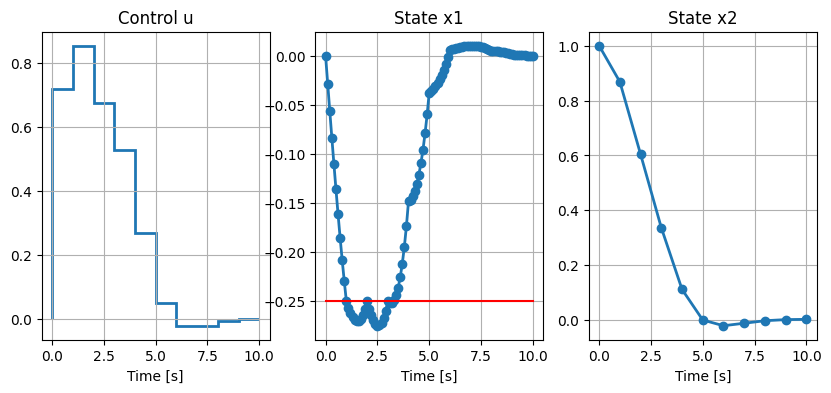

In [24]:
# Visualize results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.grid(True)
plt.stairs(u_sol[:-1], t_u, linewidth=2)
plt.xlabel("Time [s]")
plt.title('Control u')
plt.subplot(1, 3, 2)
plt.grid(True)
plt.plot(t_x1, x1_sol, '-o', linewidth=2)
plt.plot(t_x1, -0.25*ones(t_x1.shape), 'r')
plt.xlabel("Time [s]")
plt.title('State x1')
plt.subplot(1, 3, 3)
plt.grid(True)
plt.plot(t_x2, x2_sol, '-o', linewidth=2)
plt.xlabel("Time [s]")
plt.title('State x2')
plt.show(block=True)

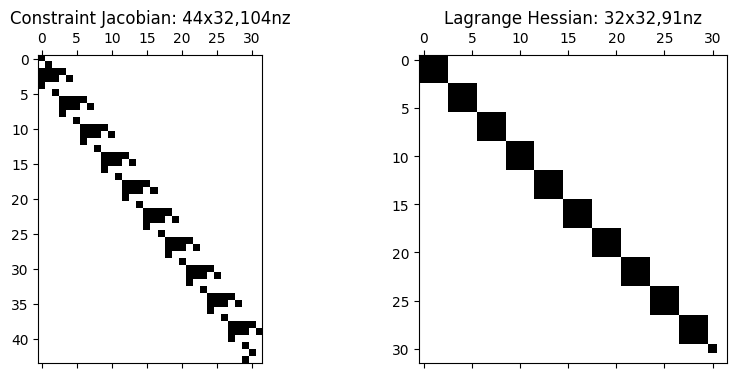

In [25]:
ocp.spy()

## Formulating an OCP: Car example

Imagine you want to improve your best lap time on an electric race track. Let's find the optimal inputs to apply.
Based on the curvature of the track, we can derive a velocity limit.

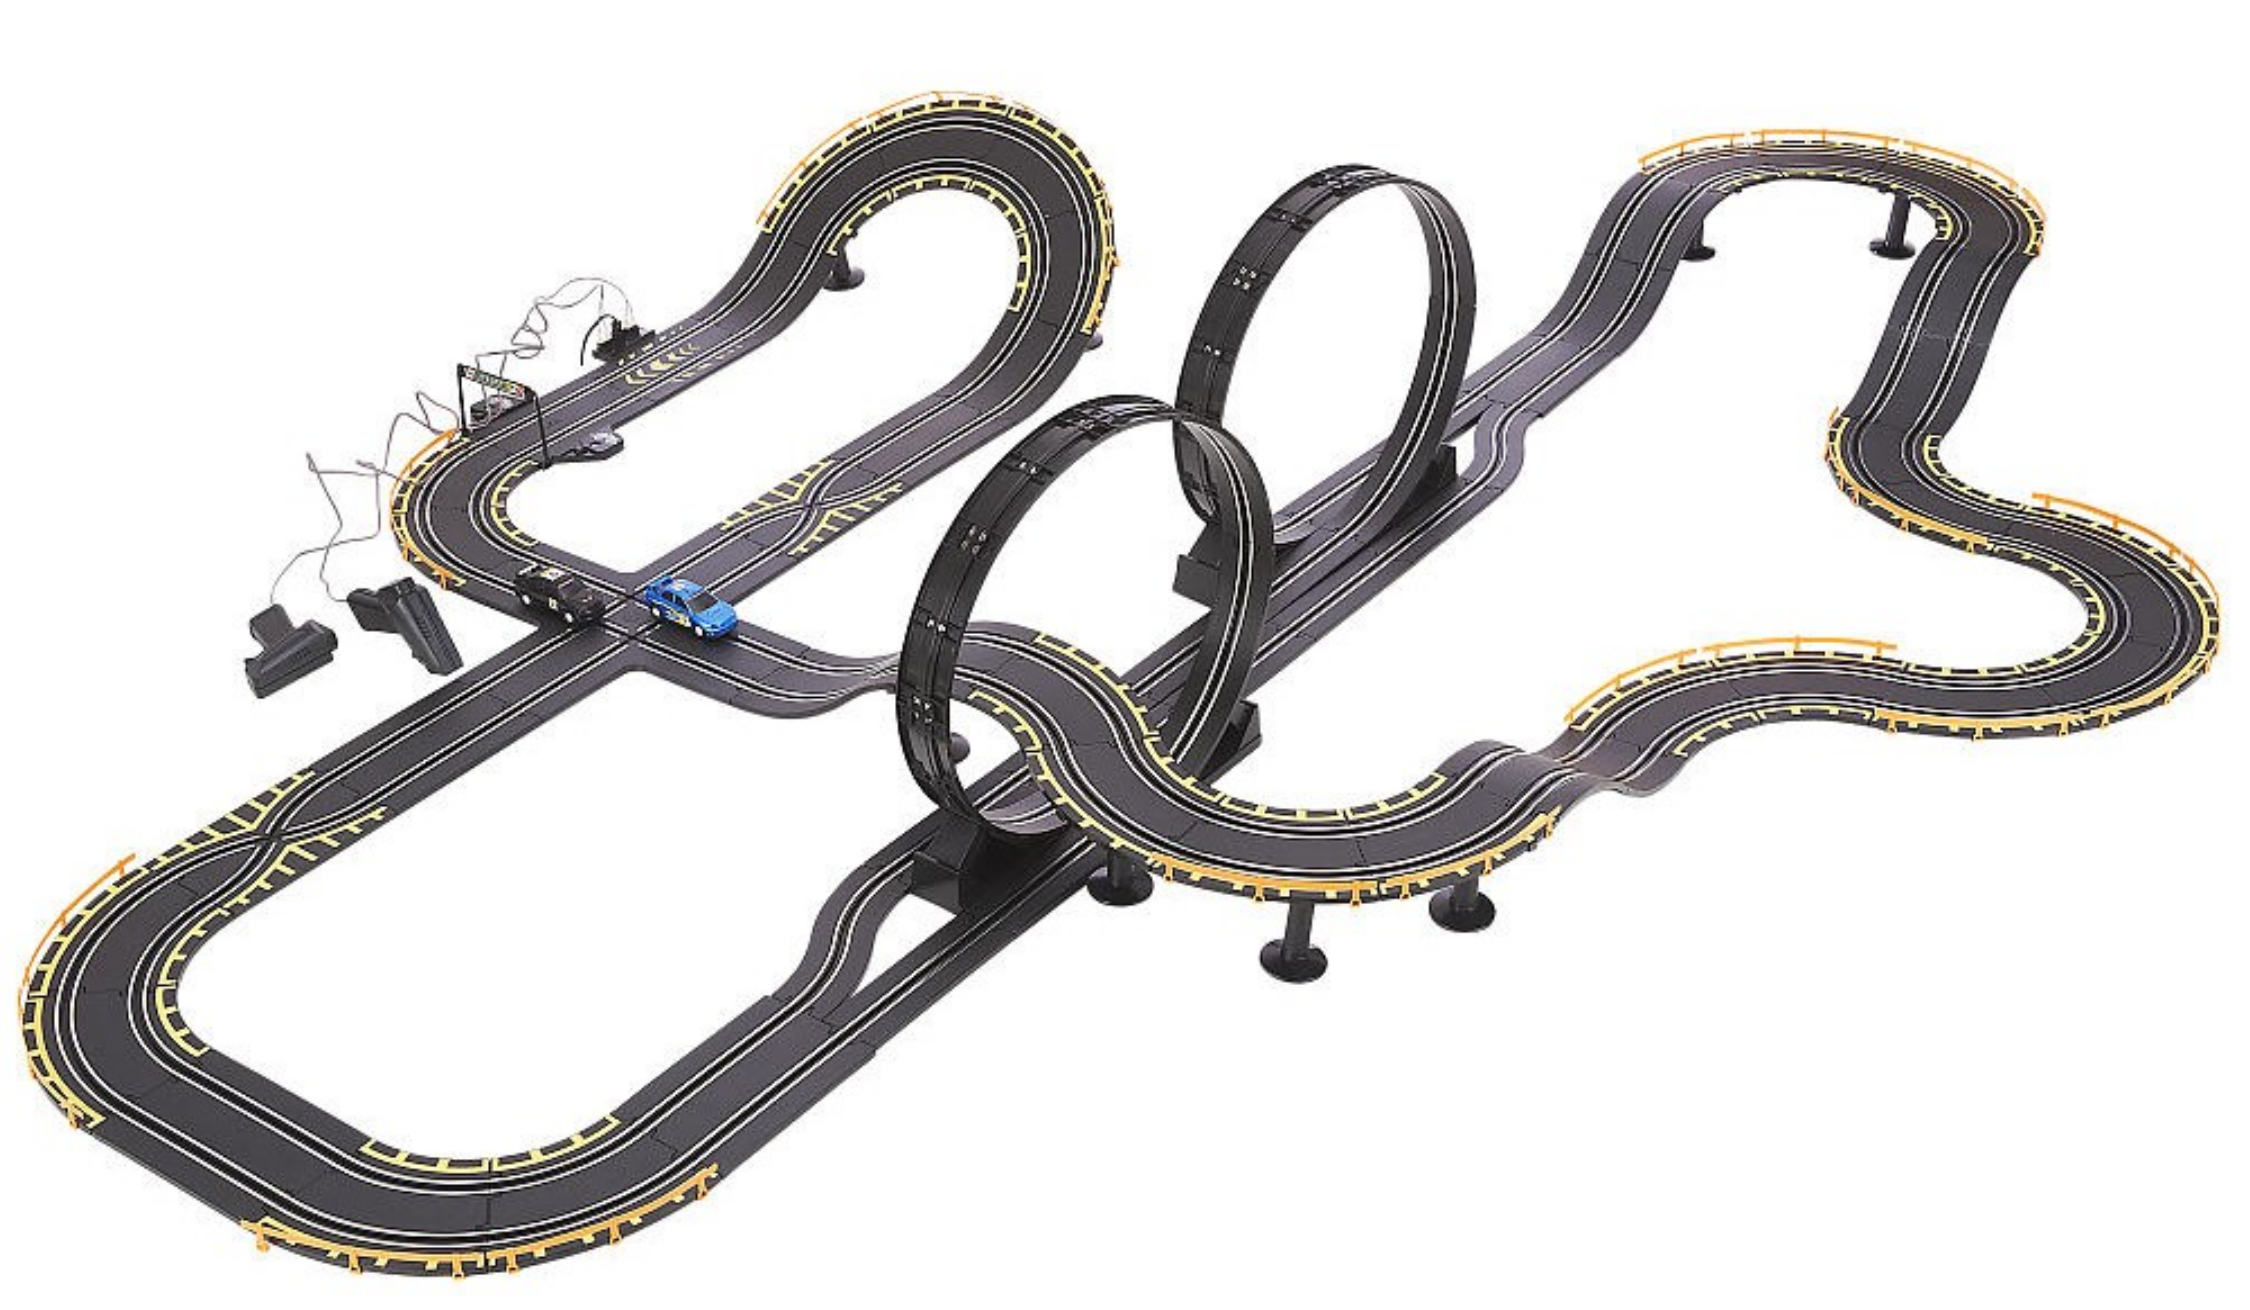

* $p,v$: position and velocity along track [m], [m/s]
* $F$: forward thrust [N]
* $F_{max} = 0.5$N: maximal thrust
* $m = 0.5$kg: mass of the car
* $c = 0.1$: drag coefficient of the car
* $d = 10$m: total distance to be covered
* $v_{max}(p) = 2 - \frac{2}{1+e^{2(p-2)^2}} - \frac{1}{1+e^{4(p-7)^2}}$m/s: maximum velocity to not fly out of control

$
\begin{aligned}
& \underset{p(\bullet),v(\bullet),F(\bullet),T}{\text{minimize}}
& &  T \\
& \text{subject to} 
& & \dot{p}(t) = v(t) ,\quad t \in [0,T]\\
& & & \dot{v}(t) = (F(t)-c v^2(t))/m,\quad t \in [0,T] \\
& & & v(t) \geq 0 ,\quad t \in [0,T]\\
& & & -F_{max} \leq F(t) \leq F_{max} ,\quad t \in [0,T]\\
& & & 0 v(t) \leq v_{max}(p) ,\quad t \in [0,T]\\
& & & p(0) = 0, v(0) = 0\\
& & & p(T) = d, v(T) = 0\\
\end{aligned}
$

A free end-time can be specified with ```ocp = Ocp(T=FreeTime(1.0))``` (initial guess 1.0)

Use ```ocp.T``` to access the optimization variable 



In [2]:
from rockit import *
from numpy import sin, pi
import casadi as cs
from casadi import *
import matplotlib.pyplot as plt

ocp = Ocp(T=FreeTime(10.0))

# Define constants
m = 0.5
c = 0.1
d = 10
F_max = 0.5

# Define states
p = ocp.state()
v = ocp.state()

# Defince controls
F = ocp.control()

# Specify ODE
ocp.set_der(p, v)
ocp.set_der(v, 1/m * (F - c*v**2))

# Lagrange objective
ocp.add_objective(ocp.T)

# Path constraints
ocp.subject_to(-F_max <= (F <= F_max))
vel_limit = 2 - 2/(1 + cs.exp(2*(p-2)**2)) - 1/(1 + cs.exp(4*(p-7)**2))
ocp.subject_to(0 <= (v <= vel_limit))

# Initial constraints
ocp.subject_to(ocp.at_t0(p)==0)
ocp.subject_to(ocp.at_t0(v)==0)

# End constraints
ocp.subject_to(ocp.at_tf(p)==d)
ocp.subject_to(ocp.at_tf(v)==0)

# Pick a solver
ocp.solver('ipopt')

# Choose a solution method
ocp.method(MultipleShooting(N=40, M=1, intg='rk'))

# solve
sol = ocp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      364
Number of nonzeros in inequality constraint Jacobian.:      165
Number of nonzeros in Lagrangian Hessian.............:      242

Total number of variables............................:      123
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality c

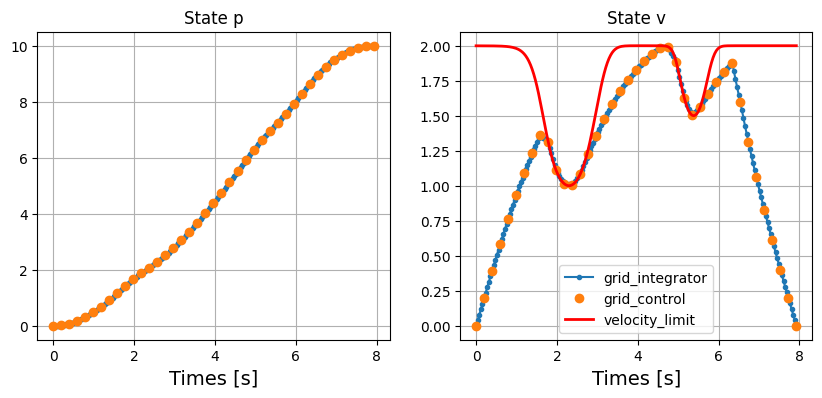

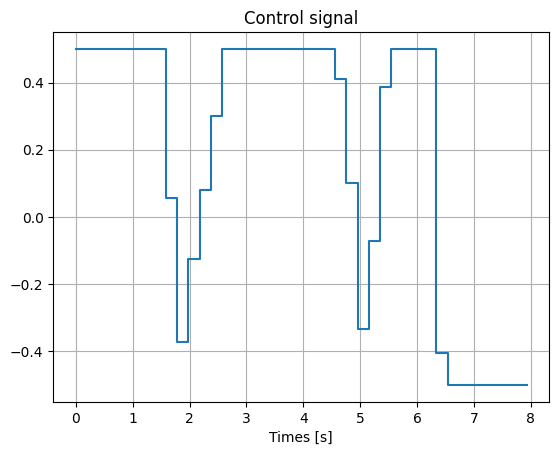

In [3]:
# Retrieving the results
tsa, pa = sol.sample(p, grid='control')
tsa, va = sol.sample(v, grid='control')

tsb, pb = sol.sample(p, grid='integrator', refine=5)
tsb, vb = sol.sample(v, grid='integrator', refine=5)

ts_lim, v_lim = sol.sample(vel_limit, grid='integrator', refine=5)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(tsb, pb, '.-')
plt.plot(tsa, pa, 'o')
plt.xlabel("Times [s]", fontsize=14)
plt.grid(True)
plt.title('State p')

plt.subplot(1, 2, 2)
plt.plot(tsb, vb, '.-')
plt.plot(tsa, va, 'o')
plt.plot(ts_lim, v_lim, 'r', linewidth=2)
plt.legend(['grid_integrator', 'grid_control', 'velocity_limit'])
plt.xlabel("Times [s]", fontsize=14)
plt.title('State v')
plt.grid(True)

tsol, usol = sol.sample(F, grid='control')

plt.figure()
plt.step(tsol,usol,where='post')
plt.title("Control signal")
plt.xlabel("Times [s]")
plt.grid(True)

plt.show(block=True)

## Beyond canonical optimal control

### include_first and include_last
If position is already fixed at t0 by initial constraints: include_first = False avoids adding a redundant constraint.

`ocp.subject_to(-pos_min <= (pos <= pos_max), include_first=False)`

</br>

### discrete time dynamics
use an update rule for a discrete state (in stead of `ocp.set_der()`), e.g. if you want to use your own integrator.

`ocp.set_next(x, -x)`

</br>

### variables
e.g. design variables, slack variables.

$
\begin{aligned}
& \underset{x(\bullet),u(\bullet), \color{red}{m}}{\text{minimize}}
& &  J(x(\bullet),u(\bullet),{\color{red}{m}}) & \text{objective} \\\\
& \text{subject to} 
& & \dot{x}(t) = f(x(t),u(t),{\color{red}{m}}) ,\quad t \in [0,T] & \quad \text{dynamic constraints}\\\\
& & & h(x(t),u(t)) \leq 0 ,\quad t \in [0,T] & \quad \text{path constraints}\\\\
& & & B(x(0),x(T)) \leq 0 & \quad \text{boundary constraints}\\\\
\end{aligned}
$

A variable can be specified as `m = ocp.variable()`

</br>

### parameters
parametric optimization (not optimized).

$
\begin{aligned}
& \underset{x(\bullet),u(\bullet)}{\text{minimize}}
& &  J(x(\bullet),u(\bullet),{\color{red}{p}}) & \text{objective} \\\\
& \text{subject to} 
& & \dot{x}(t) = f(x(t),u(t),{\color{red}{p}}) ,\quad t \in [0,T] & \quad \text{dynamic constraints}\\\\
& & & h(x(t),u(t)) \leq 0 ,\quad t \in [0,T] & \quad \text{path constraints}\\\\
& & & B(x(0),x(T)) \leq 0 & \quad \text{boundary constraints}\\\\
\end{aligned}
$

A parameter can be specified as `p = ocp.parameter()`

Fast re-solves:

`ocp.set_value(p, 5)`

`sol1 = ocp.solve()`

`ocp.set_value(p, 6)`

`sol2 = ocp.solve()`

</br>

### ocp functions

In [28]:
from rockit import *
from numpy import sin, pi
from casadi import vertcat
import numpy as np
import matplotlib.pyplot as plt

ocp = Ocp(T=FreeTime(1.0))

# Define constants
m = 500
c = 2
d = 1000

# Define states
p = ocp.state()
v = ocp.state()

# Defince controls
F = ocp.control()

# Specify ODE
ocp.set_der(p, v)
ocp.set_der(v, 1/m * (F - c * v**2))

# Lagrange objective
ocp.add_objective(ocp.T)

# Define parameters
F_max = ocp.parameter(grid='control')
p0 = ocp.parameter()

# Path constraints
ocp.subject_to(-F_max <= (F<= F_max))
ocp.subject_to(v >= 0)

# Initial constraints
ocp.subject_to(ocp.at_t0(p)==p0)
ocp.subject_to(ocp.at_t0(v)==0)

# End constraints
ocp.subject_to(ocp.at_tf(p)==d)
ocp.subject_to(ocp.at_tf(v)==0)

# Pick a solver
ocp.solver('ipopt')

# Choose a solution method
ocp.method(MultipleShooting(N=20,M=1,intg='rk'))

# Set values for parameters
ocp.set_value(p0, 1)
ocp.set_value(F_max, 2500*np.ones(20))

# Translate problem to function
T = ocp.value(ocp.T)
states = ocp.sample(vertcat(p,v), grid='control')[1]
controls = ocp.sample(F, grid='control-')[1]
test = ocp.to_function('ocp_function', [p0, ocp.sample(F_max,grid='control-')[1], T, states, controls], 
                       [ocp.sample(F,grid='control')[1], T, states, controls])

# Initial value
sol_T = 1.0
sol_states = 0
sol_controls = 0

# Solve problem for different values for parameters, initializing with previous solution
signal1, sol_T, sol_states1, sol_controls = test(0, 2500*np.ones(20), sol_T, sol_states, sol_controls)
signal2, sol_T, sol_states2, sol_controls = test(0, 2500*np.ones(20), sol_T, sol_states1, sol_controls)
signal3, sol_T, sol_states3, sol_controls = test(0, 2000*np.ones(20), sol_T, sol_states2, sol_controls)


print(signal1[:4], sol_states1[:4])
print(signal2[:4], sol_states2[:4])
print(signal3[:4], sol_states3[:4])

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      184
Number of nonzeros in inequality constraint Jacobian.:       43
Number of nonzeros in Lagrangian Hessian.............:      101

Total number of variables............................:       63
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       43
        inequality constraints with only lower bounds:       22
   inequality constraints with lower and upper bounds:       21
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

### multi stage
multiple optimal control problems stitched together, e.g. rocket launch or a bouncing ball

$
\begin{aligned}
& \underset{x_1(\bullet),u_1(\bullet),x_2(\bullet),u_2(\bullet)}{\text{minimize}}
& &  {\color{red}{J}}_1(x_1(\bullet),u_1(\bullet))+{\color{red}{J}}_2(x_2(\bullet),u_2(\bullet)) \\
& \text{subject to} 
& & \dot{x}_1(t) = {\color{red}{f}}_1(x_1(t),u_1(t)) ,\quad t \in \color{red}{[0,T_1]}\\
& & & \dot{x}_2(t) = {\color{red}{f}}_2(x_2(t),u_2(t)) ,\quad t \in \color{red}{[T_1,T_2]}\\
& & & h_1(x_1(t),u_1(t)) \leq 0 ,\quad t \in [0,T_1]\\
& & & h_2(x_2(t),u_2(t)) \leq 0 ,\quad t \in [T_1,T_2]\\
& & & B_1(x_1(0),x_1(T_1)) \leq 0\\
& & & \color{red}{C}(x_1(T_1),x_2(T_1)) \leq 0\\
& & & B_2(x_2(T_1),x_2(T_2)) \leq 0\\
\end{aligned}
$


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       41
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:       12
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.81e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

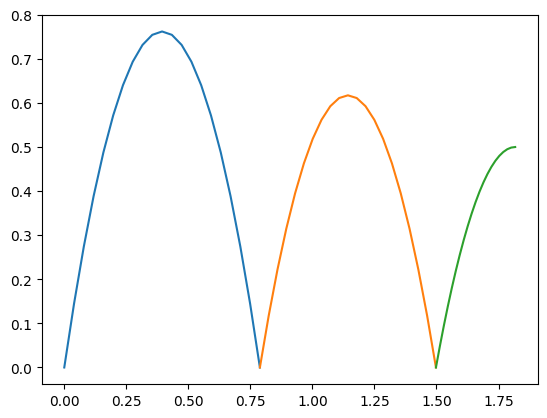

In [4]:
from rockit import Ocp, DirectMethod, MultipleShooting, FreeTime
import matplotlib.pyplot as plt


def create_bouncing_ball_stage(ocp):
    """
    Create a bouncing ball stage.

    This function creates a stage of a bouncing ball that bounces no higher
    than 5 meters above the ground.

    Returns
    -------
    stage : :obj:`~rockit.stage.Stage`
        An ocp stage describing the bouncing ball
    p : :obj:`~casadi.MX`
        position variable
    v : :obj:`~casadi.MX`
        velocity variable
    """
    stage = ocp.stage(t0=FreeTime(0), T=FreeTime(1))

    p = stage.state()
    v = stage.state()

    stage.set_der(p, v)
    stage.set_der(v, -9.81)

    stage.subject_to(stage.at_t0(v) >= 0)
    stage.subject_to(p >= 0)
    stage.method(MultipleShooting(N=1, M=20, intg='rk'))

    return stage, p, v


ocp = Ocp()

# Shoot up the ball
stage1, p1, v1 = create_bouncing_ball_stage(ocp)
ocp.subject_to(stage1.t0 == 0)  # Stage starts at time 0
ocp.subject_to(stage1.at_t0(p1) == 0)
ocp.subject_to(stage1.at_tf(p1) == 0)

# After bounce 1
stage2, p2, v2 = create_bouncing_ball_stage(ocp)
ocp.subject_to(stage2.at_t0(v2) == -0.9 * stage1.at_tf(v1))
ocp.subject_to(stage2.at_t0(p2) == stage1.at_tf(p1))
ocp.subject_to(stage2.t0 == stage1.tf)
ocp.subject_to(stage2.at_tf(p2) == 0)

# After bounce 2
stage3, p3, v3 = create_bouncing_ball_stage(ocp)
ocp.subject_to(stage3.at_t0(v3) == -0.9 * stage2.at_tf(v2))
ocp.subject_to(stage3.at_t0(p3) == stage2.at_tf(p2))
ocp.subject_to(stage3.t0 == stage2.tf)
ocp.subject_to(stage3.at_tf(v3) == 0)
ocp.subject_to(stage3.at_tf(p3) == 0.5)  # Stop at a half meter!

ocp.solver('ipopt')

# Solve
sol = ocp.solve()

# Plot the 3 bounces
plt.figure()
ts1, ps1 = sol(stage1).sample(p1, grid='integrator')
ts2, ps2 = sol(stage2).sample(p2, grid='integrator')
ts3, ps3 = sol(stage3).sample(p3, grid='integrator')
plt.plot(ts1, ps1)
plt.plot(ts2, ps2)
plt.plot(ts3, ps3)

plt.show(block=True)


## Tips on solving optimal control problems

* Start with a fixed time-horizon

* Start with good initial guesses (value, vector or expression as function of time), e.g. `ocp.set_initial(x, sin(ocp.t))`
* Start with only initial constraints and gradually add more constraints
* Start with hard-coded control signals, e.g. `u = 1` instead of `u = ocp.control()`. Does the system evolve as expected?
* Some constraints make the problem easier to solve, e.g. `ocp.subject_to(-0.5 <= pitch <= 0.5)` for a passenger aircraft. You don't want the solver to explore loopings
* If your system has a natural equilibrium state, you can add some "regularization" i.e. quadratic penalty of your actual state w.r.t. to that equilibrium state. Again, this can avoid ending up in funny trajectories that are locally infeasible  
* If the solver does not converge, you can still make plots with `sol = ocp.non_converged_solution`, or show problematic constraints with `ocp.show_infeasibilities(1e-6)`
* Scale your decision variables on physical insights such that they are order of magnitude 0.01-100. If you model rocket launches, don't use [N] as unit for thrust control; use [MN]